# Test SINDy on Lorenz System

This code demonstrates three methods to identify the governing equations of a non-linear dynamical system.

The system used in these examples is the [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system) of ordinary differential equations.

Contents:
1. Generate data by simulating Lorenz system
2. Identify system dynamics using sparse regression
 1. Using SINDy recursive least-squares method
 2. Using L1-regularized feature selection in Scikit-Learn
 3. Using L1-regularized feature selection in Scikit-Learn with cross-validation

References:

1. Brunton, S. L., & Kutz, J. N. (2019). Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control (1st ed.). Cambridge University Press. http://www.databookuw.com

In [1]:
from functools import partial
import numpy as np
import pandas as pd
from scipy.integrate import odeint

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, \
                                 MultiTaskLassoCV
from sklearn.feature_selection import SelectFromModel

# Local modules
from examples.lorenz import lorenz_odes, lorenz_odes_vectorized, \
                            scatter_plot_3d
from dynopt.models.sindy import sparsify_dynamics_lstsq
from dynopt.preprocessing.utils import polynomial_features, polynomial_feature_labels

## 1. Generate data by simulating Lorenz system

In [2]:
dt = 0.01
T = 50
t = np.arange(dt, T + dt, dt)

In [3]:
# Lorenz system parameters
beta = 8 / 3
sigma = 10
rho = 28
n = 3

In [4]:
# Initial condition
x0 = (-8, 8, 27)

In [5]:
%%time

# Simulate using scipy.integrate.odeint method
# Produces same results as Matlab
fun = partial(lorenz_odes, sigma=sigma, beta=beta, rho=rho)
rtol = 10e-12
atol = 10e-12 * np.ones_like(x0)
x = odeint(fun, x0, t, tfirst=True, rtol=rtol, atol=atol)
assert x.shape == (5000, 3)

CPU times: user 45.5 ms, sys: 1.39 ms, total: 46.9 ms
Wall time: 46.2 ms


In [6]:
x[:5]

array([[-8.        ,  8.        , 27.        ],
       [-6.48640305,  7.80317052, 25.72552262],
       [-5.13801768,  7.562589  , 24.60881074],
       [-3.94150621,  7.31298837, 23.6289285 ],
       [-2.88204816,  7.07817171, 22.76571068]])

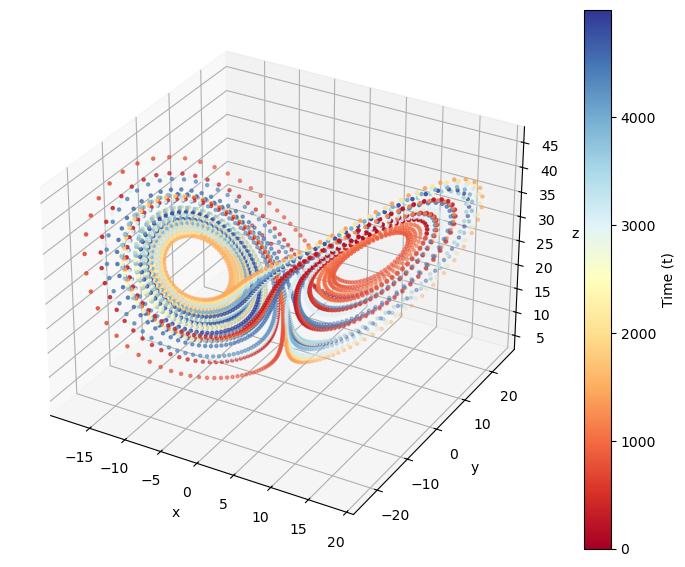

In [7]:
scatter_plot_3d(x)

In [8]:
# Calculate derivatives (vectorized version)
dx = lorenz_odes_vectorized(0, x.T, sigma, beta, rho).T
assert dx.shape == (5000, 3)

## 2. Identify system dynamics using sparse regression

### A. Using SINDy recursive least-squares method

In [9]:
lamb = 0.025  # sparsification knob lambda

In [10]:
poly_order = 2
theta = polynomial_features(x, order=poly_order)
assert theta.shape == (5000, 10)

In [11]:
# Estimate sparse dynamic model
xi = sparsify_dynamics_lstsq(theta, dx, lamb, n)
assert xi.shape == (10, 3)

In [12]:
# Coefficients found by sparse regression
xi

array([[  0.        ,   0.        ,   0.        ],
       [-10.        ,  28.        ,   0.        ],
       [ 10.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,  -2.66666667],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ],
       [  0.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ]])

In [13]:
# Display coefficients with labels
var_names = ['y1', 'y2', 'y3']
coef_labels = polynomial_feature_labels(x.shape[1], poly_order, 
                                        names=var_names)
assert len(coef_labels) == 10
pd.DataFrame(xi, columns=var_names, index=coef_labels).round(3)

,y1,y2,y3
1,0.0,0.0,0.000
y1,-10.0,28.0,0.000
y2,10.0,-1.0,0.000
y3,0.0,0.0,-2.667
y1**2,0.0,0.0,0.000
y1*y2,0.0,0.0,1.000
y1*y3,0.0,-1.0,0.000
y2**2,0.0,0.0,0.000
y2*y3,0.0,0.0,0.000
y3**2,0.0,0.0,0.000


### B. Using L1-regularized feature selection in Scikit-Learn

See: https://scikit-learn.org/stable/modules/feature_selection.html#l1-based-feature-selection

In [14]:
poly = PolynomialFeatures(poly_order)
theta = poly.fit_transform(x)
assert theta.shape == (5000, 10)
X, y = theta, dx
X.shape, y.shape

((5000, 10), (5000, 3))

In [15]:
# Set L1 penalty weight
alpha = 0.5

# Specify how many features to use
max_features = 7

# Find sparse model
estimator = Lasso(alpha=alpha)
selector = SelectFromModel(estimator, threshold=-np.inf, 
                           max_features=max_features)
selector.fit(X, y)

X_transform = selector.transform(X)
n_features = selector.transform(X).shape[1]
n_features

/Users/billtubbs/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.286e+03, tolerance: 8.633e+02
  model = cd_fast.enet_coordinate_descent(


7

In [16]:
# Fit sparse model
estimator = LinearRegression()
estimator.fit(X_transform, y)
estimator.coef_.T.round(3)

array([[-10.   ,  28.   ,  -0.   ],
       [ 10.   ,  -1.   ,   0.   ],
       [  0.   ,   0.   ,  -2.667],
       [ -0.   ,  -0.   ,   0.   ],
       [  0.   ,   0.   ,   1.   ],
       [ -0.   ,  -1.   ,   0.   ],
       [ -0.   ,   0.   ,  -0.   ]])

In [17]:
# Display coefficients with labels
selected_features = selector.get_support()
np.array(coef_labels)[selected_features]
pd.DataFrame(estimator.coef_.T, columns=var_names[:3], 
             index=np.array(coef_labels)[selected_features]).round(3)

,y1,y2,y3
y1,-10.0,28.0,-0.000
y2,10.0,-1.0,0.000
y3,0.0,0.0,-2.667
y1**2,-0.0,-0.0,0.000
y1*y2,0.0,0.0,1.000
y1*y3,-0.0,-1.0,0.000
y2*y3,-0.0,0.0,-0.000


### C. Using L1-regularized feature selection in Scikit-Learn with cross-validation

In [18]:
# Set L1 penalty
alpha = 0.5

# Specify how many features to use
max_features = 7

estimator = MultiTaskLassoCV(cv=5, alphas=[alpha]*4)

# Set minimum threshold
selector = SelectFromModel(estimator, threshold=-np.inf, 
                           max_features=max_features)
selector.fit(X, y)

X_transform = selector.transform(X)
n_features = selector.transform(X).shape[1]
n_features

/Users/billtubbs/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:606: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39977.11050029926, tolerance: 4543.863882519841
  model = cd_fast.enet_coordinate_descent_multi_task(
/Users/billtubbs/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:606: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36119.49717177944, tolerance: 4777.442762332251
  model = cd_fast.enet_coordinate_descent_multi_task(
/Users/billtubbs/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:606: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37130.6493026947, tolerance: 4621.726623297588
  model = cd_fast.enet_coordinate_descent_multi_task(
/User

7

In [19]:
estimator = LinearRegression()
estimator.fit(X_transform, y)
estimator.coef_.T.round(3)

array([[-10.   ,  28.   ,  -0.   ],
       [ 10.   ,  -1.   ,   0.   ],
       [  0.   ,   0.   ,  -2.667],
       [ -0.   ,  -0.   ,   0.   ],
       [  0.   ,   0.   ,   1.   ],
       [ -0.   ,  -1.   ,   0.   ],
       [ -0.   ,   0.   ,  -0.   ]])

In [20]:
# Display coefficients with labels
selected_features = selector.get_support()
np.array(coef_labels)[selected_features]
pd.DataFrame(estimator.coef_.T, columns=var_names[:3], 
             index=np.array(coef_labels)[selected_features]).round(3)

,y1,y2,y3
y1,-10.0,28.0,-0.000
y2,10.0,-1.0,0.000
y3,0.0,0.0,-2.667
y1**2,-0.0,-0.0,0.000
y1*y2,0.0,0.0,1.000
y1*y3,-0.0,-1.0,0.000
y2*y3,-0.0,0.0,-0.000
